# Data redundancy in developing deep learning tools on biological data: analysis and solutions

Deep learning methods have revolutionised the development of prediction algorithms on biological data. In this project, we will study a typical problem in developing such tools, i.e. biases and redundancy in the training data. We will use a case study to see how this problem affect the training and generalisation of deep learning tools, and the effect of possible solutions to ease such issues. \\

In this project we will investigate biases and and redundancy in the training data. To do this we will try out different setups of deep learning tools. More specifically, we will use a CNN consisting of 3 layers each with different numbers of hidden units and kernel sizes. As input the model will be given a sequence and for each amino acid predict which secondary structure it is part of. Data from NetSurfP will be used.


## Monte Carlo Clustering algorithm
The initial part of this project consisted of a monte carlo clustering algorithm. Here, the idea was to implement a new clustering technique that clustered similar sequences into the same clusters. This is done by performing random choices for *i* iterations. Either, it can randomly select a sequence from a random cluster and create a new cluster or it selects a random sequence from a random cluster and add it to another random cluster. To evaluate how well the solutions it converges to are we use the following formula $$Energy=violations -\log((clustersize+1)*(numberofsequences+1))$$
We try to optimize so the energy is as low as possible. To avoid our solution getting trapped into a local minimum we allow with probability to accept a worse solution. This probability is regulated by a decreasing temperature *T*. Unfortunately, this algorithm was not tested due to limited time.

In [ ]:
import numpy as np
import random
import math
from Bio import SeqIO
from copy import deepcopy

def getSeqID(Alignment1,Alignment2):
    IDres = 0
    noIDres = 0
    noRes = 0
    SeqLen = len(Alignment1)
    # Counting how many residues are identical.
    for i in range(SeqLen):
        if Alignment1[i] == Alignment2[i] and Alignment1[i] != '-':
            IDres += 1
        elif Alignment1[i] == '-' and Alignment2[i] == '-':
            noRes += 1
        else:
            noIDres += 1
    # Calculating score
    score = IDres / (SeqLen - noRes)
    return score


def MCClusterSeq(fastafile,threshold=0.6,maxiter=10000,T=1000):
    np.random.seed(33)
    random.seed(33)
    # Reading in the sequences
    fasta_sequences = SeqIO.parse(open(fastafile),'fasta')
    sequencelist = []
    NameSeq = []
    for fasta in fasta_sequences:
        sequencelist.append(str(fasta.seq))
        NameSeq.append(fasta.id)
    numseqs = len(sequencelist)
    violations = 0
    # Creating dictionay for sequences
    SeqDict = dict(zip(NameSeq,sequencelist))
    # Storing all sequence identity comparisons in an numpy matrix
    SeqMa = np.zeros((len(SeqDict),len(SeqDict)))
    i = 0
    for seq1 in SeqDict:
        j = 0
        for seq2 in SeqDict:
            if j > i:
                SeqMa[i,j] = getSeqID(SeqDict[seq1],SeqDict[seq2])
            j += 1
        i += 1
    SeqMa = SeqMa + SeqMa.T
    np.fill_diagonal(SeqMa,1)
    # Initializing with one big cluster
    clust = [[i] for i in sequencelist[:]]
    clust.insert(0,[])
    Eold = violations - np.log((len(clust) + 1) * (numseqs + 1))
    # Starting the monte carlo
    for step in range(maxiter):
        print('Step ',step + 1,' of ',maxiter)
        violations = 0
        # Decrease T for each step
        T = 0.99 * T
        # Copy the best clust and its energy
        clusternew = deepcopy(clust)
        Enew = Eold
        # Choosing which action to perform randomly
        p1 = np.random.randint(1,3)
        # If there is only one cluster there is only one choice
        if len(clusternew) == 2:
            print('First if')
            SelElem = random.choice(clusternew[1])
            clusternew[1].remove(SelElem)
            clusternew.append([SelElem])
        # else select a random sequence from a random cluster and create a new
        # cluster with it
        elif p1 == 1:
            #print('Second if')
            SelClust = random.choice(clusternew)
            if (len(clusternew[clusternew.index(SelClust)])>0):
                SelElem = random.choice(SelClust)
                clusternew[clusternew.index(SelClust)].remove(SelElem)
                clusternew.append([SelElem])
        # or select randomly a new sequence from a random cluster and put it
        # into another cluster
        else:
            print('Else')
            SelectedCluster = random.choice(clusternew)
            if (len(clusternew[clusternew.index(SelectedCluster)])>0):
                SelElem = random.choice(SelectedCluster)
                count = 0
                while True:
                    SelClust = random.choice(clusternew)
                    if SelClust != SelectedCluster:
                        break
                    elif SelElem in SelClust:  #why?
                        print(SelElem,' is in SelClust')
                        count += 1
                        if count == 10:
                            break
                clusternew[clusternew.index(SelectedCluster)].remove(SelElem)
                SelClust.append(SelElem)
        # Remove empty lists
        clusternew2 = [clust2 for clust2 in clusternew[1:] if clust2 != []]
        clusternew2.insert(0,clusternew[0])
        clusternew = clusternew2
        # Find how many violations there are in the new clustering
        for clust3 in clusternew[1:]:
            for clust4 in clusternew[1:]:
                if clust3!=clust4:
                    for elem1 in clust3:
                        for elem2 in clust4:
                            if SeqMa[sequencelist.index(elem1),sequencelist.index(elem2)] > threshold:
                                    violations += 1
        # Calculating the new energy
        Enew = violations - np.log((len(clusternew) + 1) * (numseqs + 1))
        # If it is better we accept the new clusters
        if Enew < Eold:
            clust = clusternew[:]
            Eold = Enew
        # Otherwise we randomly select a random number betwen 0 and 1 and if
        # the probability calculated from the difference in new and old energy
        # divided by T is greater than the random number we accept the new cluster
        # to escape a local minima.
        else:
            p = random.uniform(0,1)
            if p < math.exp((Eold - Enew)/T):
                clust = clusternew[:]
                Eold = Enew
    # Return the clustering
    return clust

## CNN architecture
We created a convolutional neural network to test different strategies to train a model for predicting secondary structural elements of proteins given the amino acid sequence. Here, we have tested the model with different regularization techniques: \\
- Dropout \\
- L2 penalty term \\
- Batch normalization \\



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax
from torch.autograd import Variable
import torch.nn as nn
import sklearn.model_selection as model_selection
import pickle

# Defining a function to obtain the prediction accuracies
def getAccuracy(predictions,targets):
    targets = np.squeeze(targets.permute(0,2,1).argmax(dim=2).view(-1,targets.shape[0]*targets.shape[2]).data.numpy())
    pred = np.squeeze(softmax(predictions.permute(0,2,1),dim=2).argmax(dim=2).view(-1,predictions.shape[0]*predictions.shape[2]).data.numpy())
    correct = 0
    pred = pred[targets != 8]
    targets = targets[targets != 8]
    correct = (pred == targets).sum()
    return correct/np.size(targets)

### Load train and test data
traindata = pickle.load(open('train.pickle','rb'))
X = traindata[0][:,:,0:20]
y = traindata[0][:,:,57:65]
CASP12data = pickle.load(open('Casp12Data.pickle','rb'))
X_casp = CASP12data[0][:,:,0:20]
y_casp = CASP12data[0][:,:,57:65]
TS115data = pickle.load(open('TS115.pickle','rb'))
X_TS115 = TS115data[0][:,:,0:20]
y_TS115 = TS115data[0][:,:,57:65]
CB513data = pickle.load(open('CB513.pickle','rb'))
X_CB513 = CB513data[0][:,:,0:20]
y_CB513 = CB513data[0][:,:,57:65]

# Since smaller sequences are extrapolated with zeros to match the length of
# the longest sequence in the dataset we need to add a "ninth" class of SS in 
# order not to make Pythn confuse the first class with the extrapolated ones
if y.shape[2] == 8:
    EPzeros = np.expand_dims(np.zeros((y.shape[1])),1)
    EPzeros_casp = np.expand_dims(np.zeros((y_casp.shape[1])),1)
    EPzeros_TS115 = np.expand_dims(np.zeros((y_TS115.shape[1])),1)
    EPzeros_CB513 = np.expand_dims(np.zeros((y_CB513.shape[1])),1)
    y = np.asarray([np.hstack((y[i],EPzeros)) for i in range(y.shape[0])])
    y_casp = np.asarray([np.hstack((y_casp[i],EPzeros_casp)) for i in range(y_casp.shape[0])])
    y_TS115 = np.asarray([np.hstack((y_TS115[i],EPzeros_TS115)) for i in range(y_TS115.shape[0])])
    y_CB513 = np.asarray([np.hstack((y_CB513[i],EPzeros_CB513)) for i in range(y_CB513.shape[0])])
    for i in range(y.shape[0]):
        for j in range(y[i].shape[0]):
            if np.all(y[i][j,:] == 0):
                y[i][j,:][-1] = 1
    for i in range(y_casp.shape[0]):
        for j in range(y_casp[i].shape[0]):
            if np.all(y_casp[i][j,:] == 0):
                y_casp[i][j,:][-1] = 1
    for i in range(y_TS115.shape[0]):
        for j in range(y_TS115[i].shape[0]):
            if np.all(y_TS115[i][j,:] == 0):
                y_TS115[i][j,:][-1] = 1
    for i in range(y_CB513.shape[0]):
        for j in range(y_CB513[i].shape[0]):
            if np.all(y_CB513[i][j,:] == 0):
                y_CB513[i][j,:][-1] = 1

# Converting to tensors for PyTorch
X_train = torch.tensor(X, dtype = torch.float)
y_train = torch.tensor(y, dtype = torch.float).permute(0,2,1)
X_casp = torch.tensor(X_casp,dtype = torch.float)
y_casp = torch.tensor(y_casp,dtype=torch.float).permute(0,2,1)
X_TS115 = torch.tensor(X_TS115,dtype=torch.float)
y_TS115 = torch.tensor(y_TS115,dtype=torch.float).permute(0,2,1)
X_CB513 = torch.tensor(X_CB513,dtype=torch.float)
y_CB513 = torch.tensor(y_CB513,dtype=torch.float).permute(0,2,1)

class MyDataset(Dataset):
    def __init__(self, X, y):
        self.data = X
        self.targets = y

    def __getitem__(self, index):
      x = self.data[index]
      y = self.target
s[index]
      return x, y
    
    def __len__(self):
      return len(self.data)
# Creating dataloaders for training in batches for later.
batch_size = 65
TrainLoader = DataLoader(MyDataset(X_train,y_train),batch_size=batch_size)
CASPLoader = DataLoader(MyDataset(X_casp,y_casp),batch_size=3)
TS115Loader = DataLoader(MyDataset(X_TS115,y_TS115),batch_size=batch_size)
CB513Loader = DataLoader(MyDataset(X_CB513,y_CB513),batch_size=batch_size)

# Defining the CNN architecture

channels = 20
kernel_size_conv1 = 15
padding_conv1 = 7
stride_conv1 = 1
kernel_size_conv2 = 9
padding_conv2 = 4
stride_conv2 = 1
kernel_size_conv3 = 5
padding_conv3 = 2
stride_conv3 = 1

class Net(nn.Module):
    def __init__(self):
        ''''''
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=channels,out_channels=25,kernel_size=kernel_size_conv1 , stride=stride_conv1, padding=padding_conv1),
            nn.ReLU(),
            nn.BatchNorm1d(25),
            nn.Dropout(p=0.5))

        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels=25, out_channels=35, kernel_size=kernel_size_conv2, stride=stride_conv2, padding=padding_conv2),
            nn.ReLU(),
            nn.BatchNorm1d(35),
            nn.Dropout(p=0.5))

        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=35,out_channels=40, kernel_size=kernel_size_conv3, stride=stride_conv3, padding=padding_conv3),
            nn.ReLU(),
            nn.BatchNorm1d(40),
            nn.Dropout(p=0.5))

        # Using a convolutional layer instead of linear.
        self.fc1_encode1 = nn.Sequential(
            nn.Conv1d(in_channels=40,out_channels=9,kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm1d(9)
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc1_encode1(x)
        return x

net = Net()

# Defining criterion and optimizer
import torch.optim as optim

def criterion(input, target):
    labels = torch.argmax(target,2)
    #print(input)
    #print("T")
    #print(input.shape)
    #print(labels.shape)
    return nn.CrossEntropyLoss()(input, labels)

# Using thr ADAM optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001,betas=(0.85,0.95),weight_decay=1e-6)

# Training for 50 epochs
num_epoch = 50  # Your code here!
# Creating lists to store loss and accuracies in
train_loss = []
train_accuracy = []
casp_loss = []
casp_accuracy = []
TS115_loss = []
TS115_accurac = []
CB513_loss = []
CB513_accuracy = []

# Training
for epoch in range(num_epoch):  # loop over the dataset multiple times
    print('Epoch ',epoch+1,' of ',num_epoch)
    running_loss = 0.0
    running_acc = 0.0
    net.train()
    print('Training net')
    for data in TrainLoader:
        inputs, labels = data
        # Wrap them in Variable
        inputs, labels = Variable(inputs.permute(0,2,1)), Variable(labels)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        running_acc += getAccuracy(outputs,labels)
        loss = criterion(outputs,labels.permute(0,2,1))
        loss.backward()
        running_loss += loss.data.numpy()
        optimizer.step()
    # Nromalizing the error and append it to list.
    train_loss.append(running_loss/len(TrainLoader))
    # Turning off gradients while validating on test set.
    net.eval()
    with torch.no_grad():
        running_loss = 0.0
        running_acc = 0.0
        print('Testing on CASP')
        for data in CASPLoader:
            inputs, labels = data
            outputs = net(Variable(inputs.permute(0,2,1)))
            loss = criterion(outputs,labels.permute(0,2,1))
            running_acc += getAccuracy(outputs,labels)
            running_loss += loss.data.numpy()
        casp_loss.append(running_loss/len(CASPLoader))
        casp_accuracy.append(running_acc/len(CASPLoader))
        running_loss = 0.0
        running_acc = 0.0
        print('Testing on TS115')
        for data in TS115Loader:
            inputs, labels = data
            outputs = net(Variable(inputs.permute(0,2,1)))
            loss = criterion(outputs,labels.permute(0,2,1))
            running_acc += getAccuracy(outputs,labels)
            running_loss += loss.data.numpy()
        TS115_loss.append(running_loss/len(TS115Loader))
        TS115_accuracy.append(running_acc/len(TS115Loader))
        running_loss = 0.0
        running_acc = 0.0
        print('Testing on CB513')
        for data in CB513Loader:
            inputs, labels = data
            outputs = net(Variable(inputs.permute(0,2,1)))
            loss = criterion(outputs,labels.permute(0,2,1))
            running_acc += getAccuracy(outputs,labels)
            running_loss += loss.data.numpy()
        CB513_loss.append(running_loss/len(CB513Loader))
        CB513_accuracy.append(running_acc/len(CB513Loader))
print('Finished Training')
scale = list(range(1,num_epoch+1))

# Plotting of results
fig, axs = plt.subplots(1, 2, constrained_layout=False)
axs[0].plot(scale, train_loss,label='Train')
axs[0].plot(scale, casp_loss,label='CASP12')
axs[0].plot(scale, TS115_loss,label='TS115')
axs[0].plot(scale, CB513_loss,label='CB513')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(loc='upper right')
axs[1].plot(scale, train_accuracy,label='Train')
axs[1].plot(scale, casp_accuracy,label='CASP12')
axs[1].plot(scale, TS115_accuracy,label='TS115')
axs[1].plot(scale, CB513_accuracy,label='CB513')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(loc='lower right')
fig.suptitle('Dropout, BN and L2', fontsize=16,y=1.05)
plt.tight_layout()
plt.show()

### Plotting different curves for different regularization techniques
**No regularization:** \\
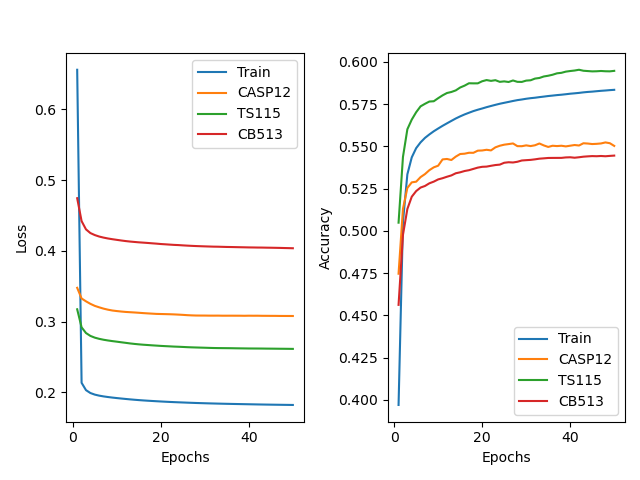

**Batch normalization:** \\
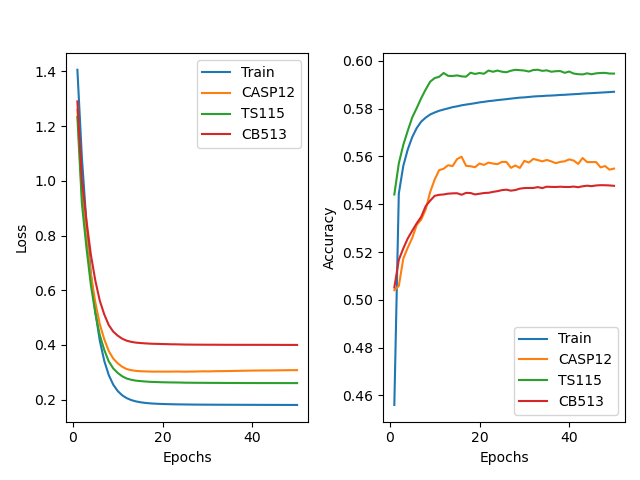

**L2 Penalty** \\
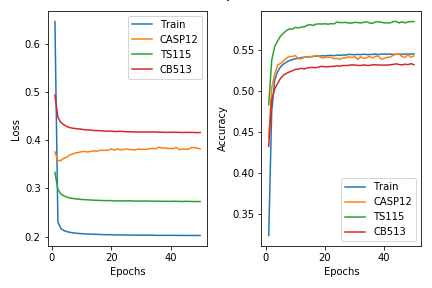

**All regularization techniques:** \\
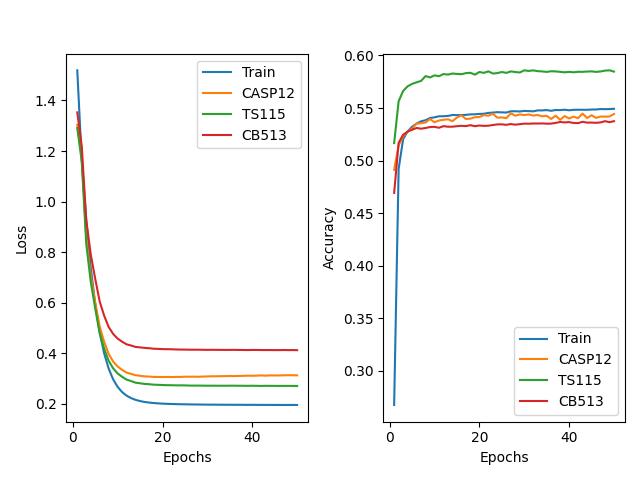